PYTHON START HERE (RIL)

Linear Kernel

Processing images in parallel...


Applying PCA to retain 90% variance...
PCA reduced dimensions to: 335 components.
Optimizing SVM hyperparameters with Bayesian Optimization...
Best hyperparameters: OrderedDict([('C', 1.1233621690895232)])
Classification accuracy with optimized parameters: 96.97%
Visualizing hyperplanes and decision boundaries...


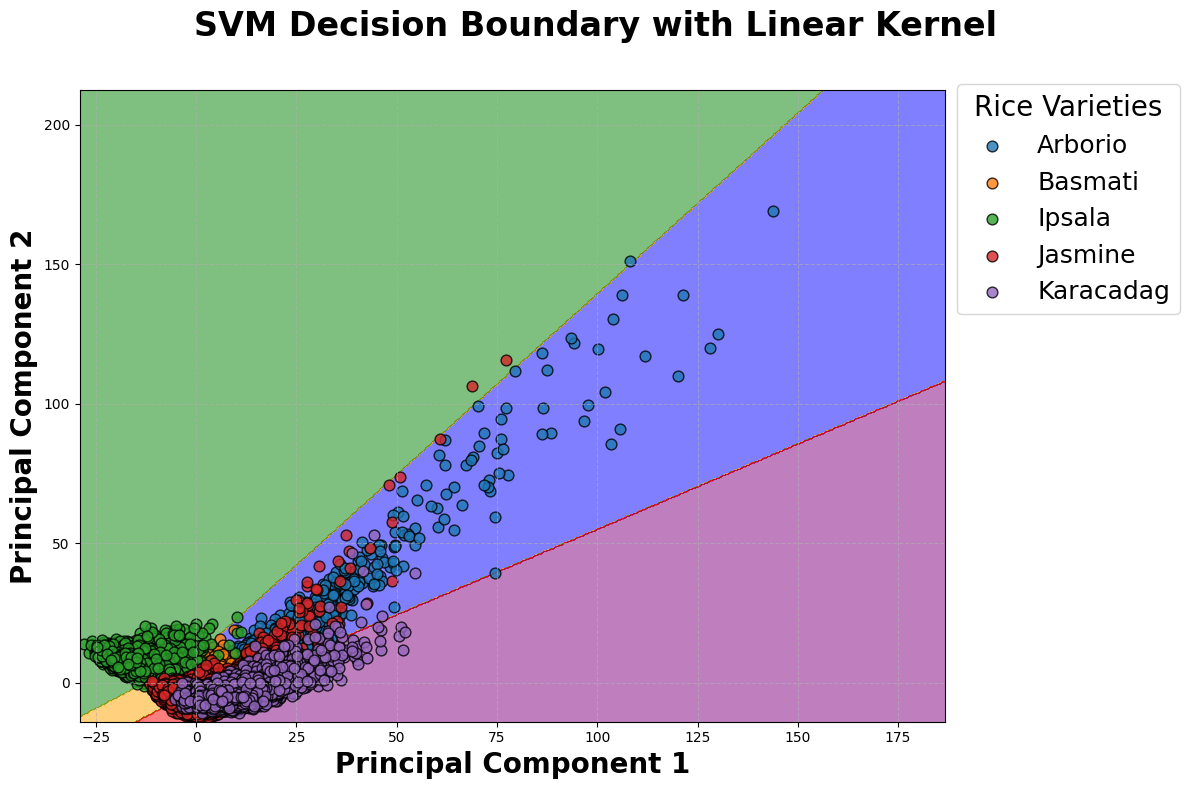

In [ ]:
import os
import numpy as np
import cv2
import joblib
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler, LabelEncoder
from skopt import BayesSearchCV
from skopt.space import Real
from tqdm import tqdm
from joblib import Parallel, delayed
from matplotlib.colors import ListedColormap
import matplotlib.pyplot as plt

# Function to extract RGB histograms from an image
def extract_histogram(img):
    hist_red = cv2.calcHist([img], [0], None, [256], [0, 256])  # Red channel
    hist_green = cv2.calcHist([img], [1], None, [256], [0, 256])  # Green channel
    hist_blue = cv2.calcHist([img], [2], None, [256], [0, 256])  # Blue channel
    return np.concatenate([hist_red.flatten(), hist_green.flatten(), hist_blue.flatten()])

# Function to process a single image
def process_image(category, i):
    img_path = f'{category}/{category} ({i}).jpg'
    img = cv2.imread(img_path)
    if img is not None:
        hist = extract_histogram(img)
        return hist, category
    return None, None

# Load images and extract features in parallel
def load_images_parallel(image_types, num_images):
    results = []
    for category in image_types:
        with Parallel(n_jobs=-1, backend='loky') as parallel:
            results.extend(
                tqdm(
                    parallel(
                        delayed(process_image)(category, i)
                        for i in range(1, num_images + 1)
                    ),
                    desc=f"Processing {category}",
                    leave=False
                )
            )
    features, labels = zip(*[res for res in results if res[0] is not None])
    return np.array(features), list(labels)

# Set parameters
image_types = ['Arborio', 'Basmati', 'Ipsala', 'Jasmine', 'Karacadag']
num_images = 10500

# Process images and extract features
print("Processing images in parallel...")
features, labels = load_images_parallel(image_types, num_images)

# Standardization
scaler = StandardScaler()
features_scaled = scaler.fit_transform(features)

# PCA for 90% variance explained
print(f"Applying PCA to retain 90% variance...")
pca = PCA(n_components=0.90)
features_pca = pca.fit_transform(features_scaled)
print(f"PCA reduced dimensions to: {features_pca.shape[1]} components.")

# Convert labels to a numerical format
label_encoder = LabelEncoder()
labels_encoded = label_encoder.fit_transform(labels)

# Split dataset
X_train, X_test, y_train, y_test = train_test_split(features_pca, labels_encoded, test_size=0.3, random_state=42)

# Bayesian Optimization for Hyperparameter Tuning
print("Optimizing SVM hyperparameters with Bayesian Optimization...")
opt = BayesSearchCV(
    SVC(kernel='linear', random_state=42, decision_function_shape='ovr'),
    search_spaces={
        'C': Real(1e-2, 1e+3, prior='log-uniform')  # Regularization parameter
    },
    n_iter=5,
    cv=3,
    n_jobs=-1,
    random_state=42
)

# Fit the model with Bayesian optimization
opt.fit(X_train, y_train)

# Get best parameters from optimization
print(f"Best hyperparameters: {opt.best_params_}")

# Evaluate SVM with the best found parameters
y_pred = opt.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Classification accuracy with optimized parameters: {accuracy * 100:.2f}%")

# Save the optimized model and components
joblib.dump(opt.best_estimator_, 'svm_model_optimized_ten.pkl')
joblib.dump(pca, 'pca_model_ten.pkl')
joblib.dump(scaler, 'scaler_model_ten.pkl')
joblib.dump(label_encoder, 'label_encoder_ten.pkl')

# Visualizing hyperplanes and decision boundaries
print("Visualizing hyperplanes and decision boundaries...")

# Reduce data to 2D for visualization
pca_2d = PCA(n_components=2)
features_2d = pca_2d.fit_transform(features_scaled)
X_train_2d, X_test_2d, y_train_2d, y_test_2d = train_test_split(features_2d, labels_encoded, test_size=0.3, random_state=42)

# Fit the SVM again using only the first two PCA components
svm_2d = SVC(kernel='linear', C=opt.best_params_['C'], random_state=42, decision_function_shape='ovr')
svm_2d.fit(X_train_2d, y_train_2d)

# Create a mesh grid for plotting decision boundaries
x_min, x_max = features_2d[:, 0].min() - 1, features_2d[:, 0].max() + 1
y_min, y_max = features_2d[:, 1].min() - 1, features_2d[:, 1].max() + 1
xx, yy = np.meshgrid(np.linspace(x_min, x_max, 500), np.linspace(y_min, y_max, 500))

# Predict for each point in the mesh grid
Z = svm_2d.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

# Plot the decision boundaries
fig, ax = plt.subplots(figsize=(12, 8))

# Define a custom color map for each class
color_map = {
    'Arborio': 'blue',
    'Basmati': 'orange',
    'Ipsala': 'green',
    'Jasmine': 'red',
    'Karacadag': 'purple'
}

# Prepare a colormap for plotting decision boundaries
colors = ListedColormap([color_map['Arborio'], color_map['Basmati'], color_map['Ipsala'], color_map['Jasmine'], 'red', color_map['Karacadag']])


# Plot contour for decision regions
ax.contourf(xx, yy, Z, alpha=0.5, cmap=colors)

# Scatter plot for each class
for i, category in enumerate(image_types):
    idx = y_train_2d == i
    ax.scatter(
        X_train_2d[idx, 0],
        X_train_2d[idx, 1],
        label=category,
        s=60,
        edgecolor='k',
        alpha=0.8
    )

# Plot settings
ax.set_xlabel('Principal Component 1', fontsize=20, weight='bold')
ax.set_ylabel('Principal Component 2', fontsize=20, weight='bold')
ax.legend(loc='upper left', bbox_to_anchor=(1, 1.03), fontsize=18, title='Rice Varieties', title_fontsize=20)
ax.grid(True, linestyle='--', alpha=0.6)

# Display the plot
plt.tight_layout()
plt.suptitle('SVM Decision Boundary with Linear Kernel', fontsize=24, weight='bold')
plt.subplots_adjust(top=0.88)
plt.show()


Loading and processing test images...



Test Classification Accuracy: 83.28%


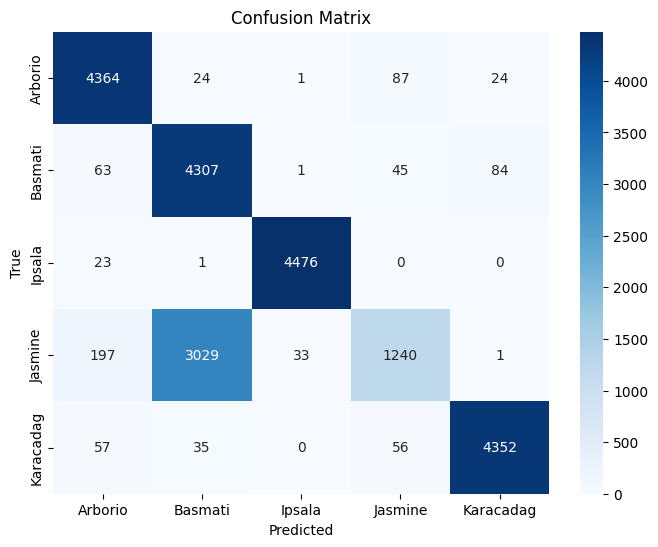

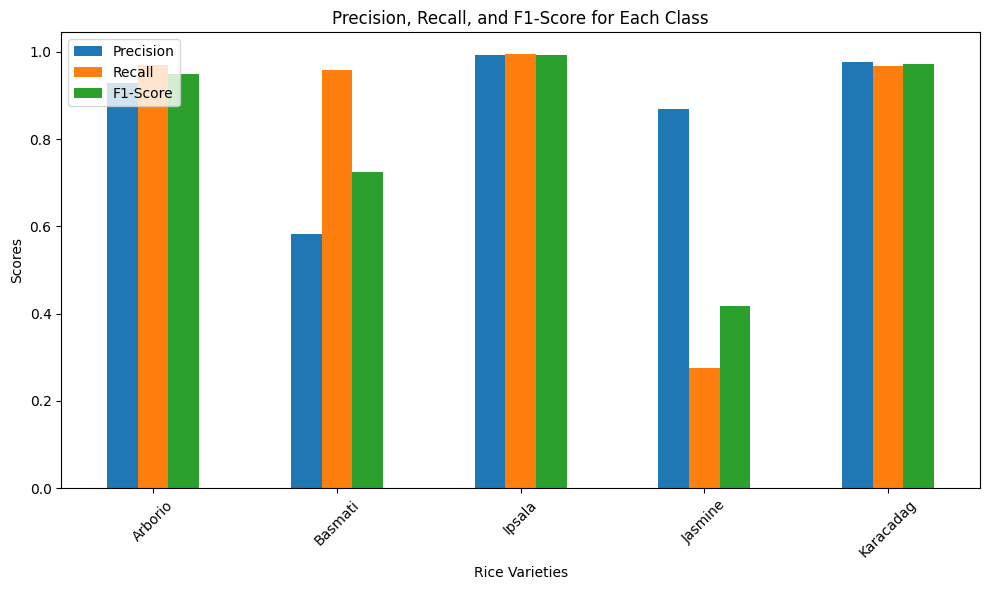


Classification Report on Test Data:

              precision    recall  f1-score   support

     Arborio       0.93      0.97      0.95      4500
     Basmati       0.58      0.96      0.72      4500
      Ipsala       0.99      0.99      0.99      4500
     Jasmine       0.87      0.28      0.42      4500
   Karacadag       0.98      0.97      0.97      4500

    accuracy                           0.83     22500
   macro avg       0.87      0.83      0.81     22500
weighted avg       0.87      0.83      0.81     22500


Visualizing Decision Boundaries with PCA Scatter Plot...


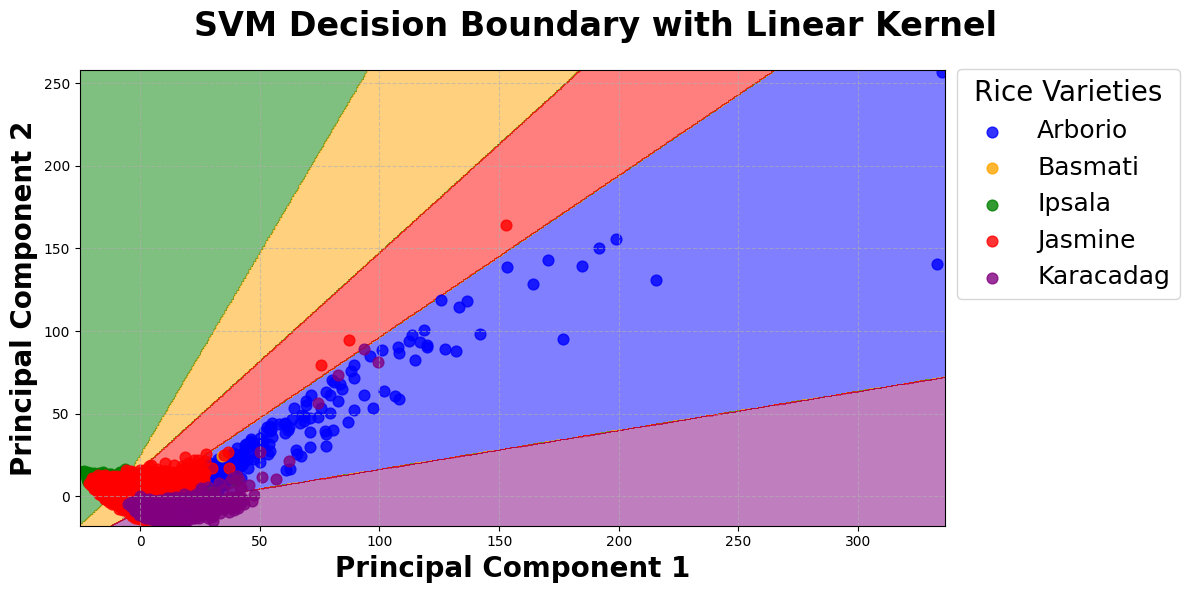


Test RMSE (Root Mean Square Error): 0.8818
Test MAE (Mean Absolute Error): 0.3515


In [ ]:
import joblib
import numpy as np
import pandas as pd
import cv2
from tqdm import tqdm
from joblib import Parallel, delayed
from sklearn.metrics import accuracy_score, confusion_matrix, precision_recall_fscore_support, classification_report, mean_squared_error, mean_absolute_error
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from matplotlib.colors import ListedColormap
import seaborn as sns
import matplotlib.pyplot as plt

# Function to extract RGB histograms from an image
def extract_histogram(img):
    hist_red = cv2.calcHist([img], [0], None, [256], [0, 256])  # Red channel
    hist_green = cv2.calcHist([img], [1], None, [256], [0, 256])  # Green channel
    hist_blue = cv2.calcHist([img], [2], None, [256], [0, 256])  # Blue channel
    return np.concatenate([hist_red.flatten(), hist_green.flatten(), hist_blue.flatten()])

# Function to process a single image
def process_image(category, i):
    img_path = f'{category}/{category} ({i}).jpg'
    img = cv2.imread(img_path)
    if img is not None:
        hist = extract_histogram(img)
        return hist, category
    return None, None

# Load test images in parallel with progress bar
def load_test_images(image_types, start_idx, end_idx):
    features, labels = [], []
    for category in image_types:
        with Parallel(n_jobs=-1, backend='loky') as parallel:
            results = list(
                tqdm(
                    parallel(
                        delayed(process_image)(category, i)
                        for i in range(start_idx, end_idx + 1)
                    ),
                    desc=f"Processing {category}",
                    leave=False
                )
            )
        category_features, category_labels = zip(*[res for res in results if res[0] is not None])
        features.extend(category_features)
        labels.extend([category] * len(category_features))
    return np.array(features), labels

# Load the optimized model and components
svm = joblib.load('svm_model_optimized_ten.pkl')
pca = joblib.load('pca_model_ten.pkl')
scaler = joblib.load('scaler_model_ten.pkl')
label_encoder = joblib.load('label_encoder_ten.pkl')

# Set parameters
image_types = ['Arborio', 'Basmati', 'Ipsala', 'Jasmine', 'Karacadag']
start_idx, end_idx = 10501, 15000

# Load test images
print("Loading and processing test images...")
test_features, test_labels = load_test_images(image_types, start_idx, end_idx)

# Preprocess test data
test_features_scaled = scaler.transform(test_features)
test_features_pca = pca.transform(test_features_scaled)
test_labels_encoded = label_encoder.transform(test_labels)

# Test the model on the new data
y_test_pred = svm.predict(test_features_pca)

# Accuracy on the test set
accuracy_test = accuracy_score(test_labels_encoded, y_test_pred)
print(f"\nTest Classification Accuracy: {accuracy_test * 100:.2f}%")

# Confusion Matrix
conf_matrix = confusion_matrix(test_labels_encoded, y_test_pred)

# Plot Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=image_types, yticklabels=image_types)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# Precision, Recall, and F1-Score
precision, recall, f1, _ = precision_recall_fscore_support(test_labels_encoded, y_test_pred, average=None)

# Create a DataFrame to show the scores
metrics_df = pd.DataFrame({
    'Precision': precision,
    'Recall': recall,
    'F1-Score': f1
}, index=image_types)

# Plot Precision, Recall, and F1-Score
metrics_df.plot(kind='bar', figsize=(10, 6))
plt.title('Precision, Recall, and F1-Score for Each Class')
plt.xlabel('Rice Varieties')
plt.ylabel('Scores')
plt.xticks(rotation=45)
plt.legend(loc='upper left')
plt.tight_layout()
plt.show()

# Display the classification report
print("\nClassification Report on Test Data:\n")
print(classification_report(test_labels_encoded, y_test_pred, target_names=image_types))

# PCA Scatter Plot with Decision Boundary
print("\nVisualizing Decision Boundaries with PCA Scatter Plot...")

# Reduce data to 2D for visualization
pca_2d = PCA(n_components=2)
test_features_2d = pca_2d.fit_transform(test_features_scaled)

# Fit a new SVM for visualization
svm_2d = SVC(kernel='linear', C=svm.C, random_state=42)
svm_2d.fit(test_features_2d, test_labels_encoded)

# Create mesh grid for decision boundary
x_min, x_max = test_features_2d[:, 0].min() - 1, test_features_2d[:, 0].max() + 1
y_min, y_max = test_features_2d[:, 1].min() - 1, test_features_2d[:, 1].max() + 1
xx, yy = np.meshgrid(np.linspace(x_min, x_max, 500), np.linspace(y_min, y_max, 500))

# Predict on the mesh grid
Z = svm_2d.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

# Define a custom color map for each class
color_map = {
    'Arborio': 'blue',
    'Basmati': 'orange',
    'Ipsala': 'green',
    'Jasmine': 'red',
    'Karacadag': 'purple'
}

# Prepare a colormap for plotting decision boundaries
cmap = ListedColormap([color_map['Arborio'], color_map['Basmati'], color_map['Ipsala'], color_map['Jasmine'], 'red', color_map['Karacadag']])

# Create the plot
fig = plt.figure(figsize=(12, 6))
ax = fig.add_subplot(111)

# Plot the decision boundaries
ax.contourf(xx, yy, Z, alpha=0.5, cmap=cmap)

# Plot the data points with specified colors
for i, category in enumerate(image_types):
    idx = test_labels_encoded == i
    ax.scatter(
        test_features_2d[idx, 0],
        test_features_2d[idx, 1],
        label=category,
        s=60,
        alpha=0.8,
        color=color_map[category]
    )

# Customize plot settings
ax.set_xlabel('Principal Component 1', fontsize=20, weight='bold')
ax.set_ylabel('Principal Component 2', fontsize=20, weight='bold')
ax.legend(loc='upper left', bbox_to_anchor=(1, 1.03), fontsize=18, title='Rice Varieties', title_fontsize=20)
ax.grid(True, linestyle='--', alpha=0.6)

# Set plot title and layout
plt.tight_layout()
plt.suptitle('SVM Decision Boundary with Linear Kernel', fontsize=24, weight='bold')
plt.subplots_adjust(top=0.88)
plt.show()

# RMSE Calculation
rmse_test = np.sqrt(mean_squared_error(test_labels_encoded, y_test_pred))
print(f"\nTest RMSE (Root Mean Square Error): {rmse_test:.4f}")

# MAE Calculation
mae_test = mean_absolute_error(test_labels_encoded, y_test_pred)
print(f"Test MAE (Mean Absolute Error): {mae_test:.4f}")


RBF KERNEL

Processing images in parallel...


Applying PCA to retain 90% variance...
PCA reduced dimensions to: 335 components.
Optimizing SVM hyperparameters with Bayesian Optimization...
Best hyperparameters: OrderedDict([('C', 115.33999859559563), ('gamma', 0.00032780432870046914)])
Classification accuracy with optimized parameters: 98.46%
Visualizing decision boundaries...


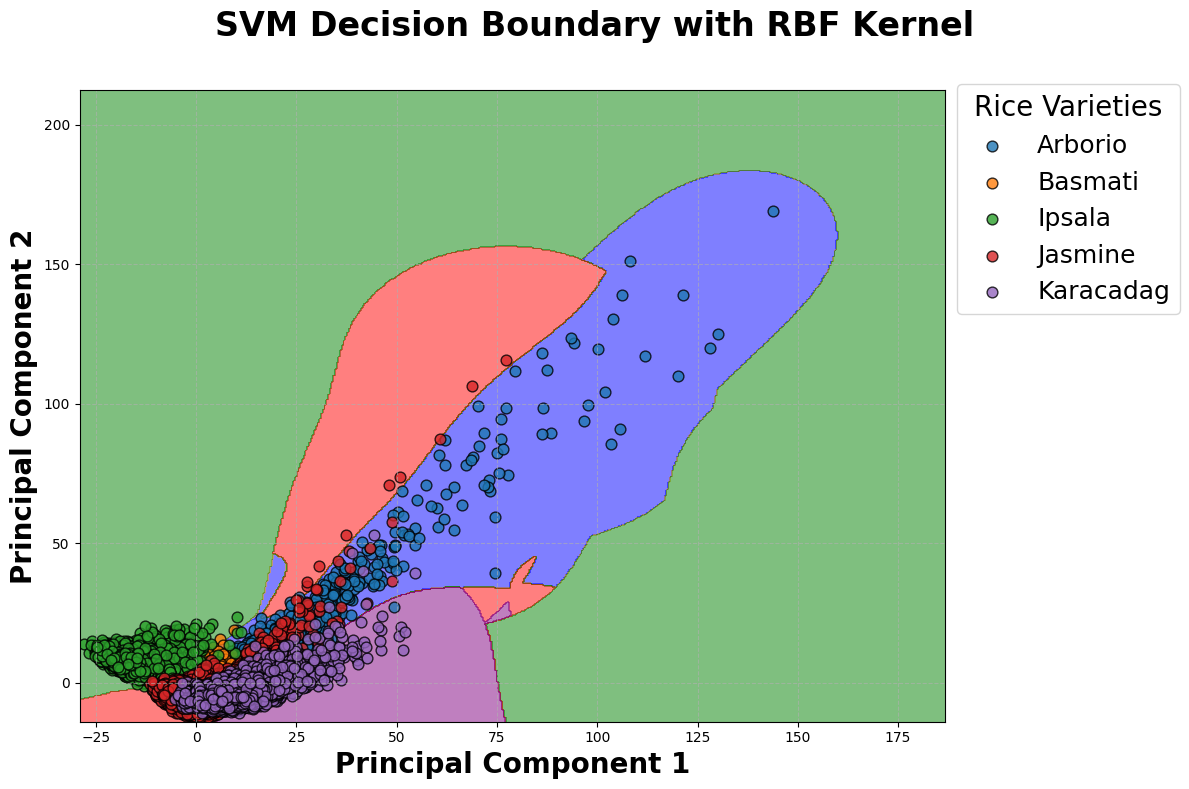

In [ ]:
import os
import numpy as np
import cv2
import joblib
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler, LabelEncoder
from skopt import BayesSearchCV
from skopt.space import Real
from tqdm import tqdm
from joblib import Parallel, delayed
from matplotlib.colors import ListedColormap
import matplotlib.pyplot as plt

# Function to extract RGB histograms from an image
def extract_histogram(img):
    hist_red = cv2.calcHist([img], [0], None, [256], [0, 256])  # Red channel
    hist_green = cv2.calcHist([img], [1], None, [256], [0, 256])  # Green channel
    hist_blue = cv2.calcHist([img], [2], None, [256], [0, 256])  # Blue channel
    return np.concatenate([hist_red.flatten(), hist_green.flatten(), hist_blue.flatten()])

# Function to process a single image
def process_image(category, i):
    img_path = f'{category}/{category} ({i}).jpg'
    img = cv2.imread(img_path)
    if img is not None:
        hist = extract_histogram(img)
        return hist, category
    return None, None

# Load images and extract features in parallel
def load_images_parallel(image_types, num_images):
    results = []
    for category in image_types:
        with Parallel(n_jobs=-1, backend='loky') as parallel:
            results.extend(
                tqdm(
                    parallel(
                        delayed(process_image)(category, i)
                        for i in range(1, num_images + 1)
                    ),
                    desc=f"Processing {category}",
                    leave=False
                )
            )
    features, labels = zip(*[res for res in results if res[0] is not None])
    return np.array(features), list(labels)

# Set parameters
image_types = ['Arborio', 'Basmati', 'Ipsala', 'Jasmine', 'Karacadag']
num_images = 10500

# Process images and extract features
print("Processing images in parallel...")
features, labels = load_images_parallel(image_types, num_images)

# Standardization
scaler = StandardScaler()
features_scaled = scaler.fit_transform(features)

# PCA for 90% variance explained
print(f"Applying PCA to retain 90% variance...")
pca = PCA(n_components=0.90)
features_pca = pca.fit_transform(features_scaled)
print(f"PCA reduced dimensions to: {features_pca.shape[1]} components.")

# Convert labels to a numerical format
label_encoder = LabelEncoder()
labels_encoded = label_encoder.fit_transform(labels)

# Split dataset
X_train, X_test, y_train, y_test = train_test_split(features_pca, labels_encoded, test_size=0.3, random_state=42)

# Bayesian Optimization for Hyperparameter Tuning
print("Optimizing SVM hyperparameters with Bayesian Optimization...")
opt = BayesSearchCV(
    SVC(kernel='rbf', random_state=42),
    search_spaces={
        'C': Real(1e-2, 1e+3, prior='log-uniform'),  # Regularization parameter
        'gamma': Real(1e-4, 1e-1, prior='log-uniform')  # Kernel coefficient
    },
    n_iter=5,
    cv=3,
    n_jobs=-1,
    random_state=42
)

# Fit the model with Bayesian optimization
opt.fit(X_train, y_train)

# Get best parameters from optimization
print(f"Best hyperparameters: {opt.best_params_}")

# Evaluate SVM with the best found parameters
y_pred = opt.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Classification accuracy with optimized parameters: {accuracy * 100:.2f}%")

# Save the optimized model and components
joblib.dump(opt.best_estimator_, 'RBF_svm_model_optimized_ten.pkl')
joblib.dump(pca, 'RBF_pca_model_ten.pkl')
joblib.dump(scaler, 'RBF_scaler_model_ten.pkl')
joblib.dump(label_encoder, 'RBF_label_encoder_ten.pkl')

# Visualizing hyperplanes and decision boundaries
print("Visualizing decision boundaries...")

# Reduce data to 2D for visualization
pca_2d = PCA(n_components=2)
features_2d = pca_2d.fit_transform(features_scaled)
X_train_2d, X_test_2d, y_train_2d, y_test_2d = train_test_split(features_2d, labels_encoded, test_size=0.3, random_state=42)

# Fit the SVM again using only the first two PCA components
svm_2d = SVC(kernel='rbf', C=opt.best_params_['C'], gamma=opt.best_params_['gamma'], random_state=42)
svm_2d.fit(X_train_2d, y_train_2d)

# Create a mesh grid for plotting decision boundaries
x_min, x_max = features_2d[:, 0].min() - 1, features_2d[:, 0].max() + 1
y_min, y_max = features_2d[:, 1].min() - 1, features_2d[:, 1].max() + 1
xx, yy = np.meshgrid(np.linspace(x_min, x_max, 500), np.linspace(y_min, y_max, 500))

# Predict for each point in the mesh grid
Z = svm_2d.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

# Plot the decision boundaries
fig, ax = plt.subplots(figsize=(12, 8))

# Define a custom color map for each class
color_map = {
    'Arborio': 'blue',
    'Basmati': 'orange',
    'Ipsala': 'green',
    'Jasmine': 'red',
    'Karacadag': 'purple'
}

# Prepare a colormap for plotting decision boundaries
colors = ListedColormap([color_map['Arborio'], color_map['Basmati'], color_map['Ipsala'], color_map['Jasmine'], color_map['Karacadag']])

# Plot contour for decision regions
ax.contourf(xx, yy, Z, alpha=0.5, cmap=colors)

# Scatter plot for each class
for i, category in enumerate(image_types):
    idx = y_train_2d == i
    ax.scatter(
        X_train_2d[idx, 0],
        X_train_2d[idx, 1],
        label=category,
        s=60,
        edgecolor='k',
        alpha=0.8
    )

# Plot settings
ax.set_xlabel('Principal Component 1', fontsize=20, weight='bold')
ax.set_ylabel('Principal Component 2', fontsize=20, weight='bold')
ax.legend(loc='upper left', bbox_to_anchor=(1, 1.03), fontsize=18, title='Rice Varieties', title_fontsize=20)
ax.grid(True, linestyle='--', alpha=0.6)

# Display the plot
plt.tight_layout()
plt.suptitle('SVM Decision Boundary with RBF Kernel', fontsize=24, weight='bold')
plt.subplots_adjust(top=0.88)
plt.show()


Loading and processing test images...



Test Classification Accuracy: 84.80%


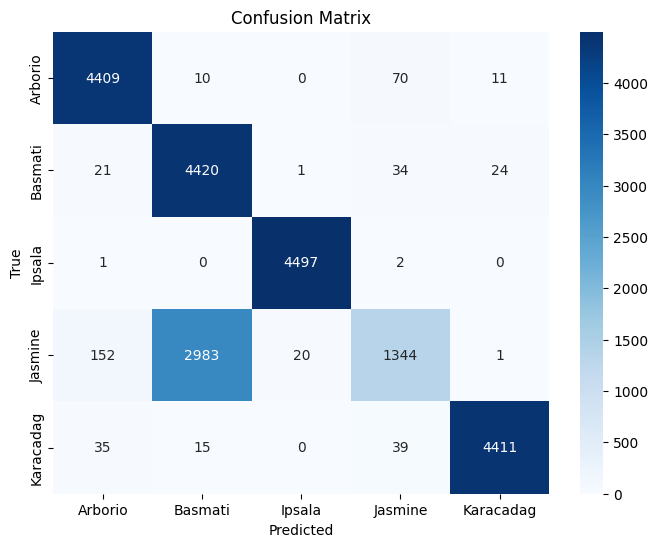

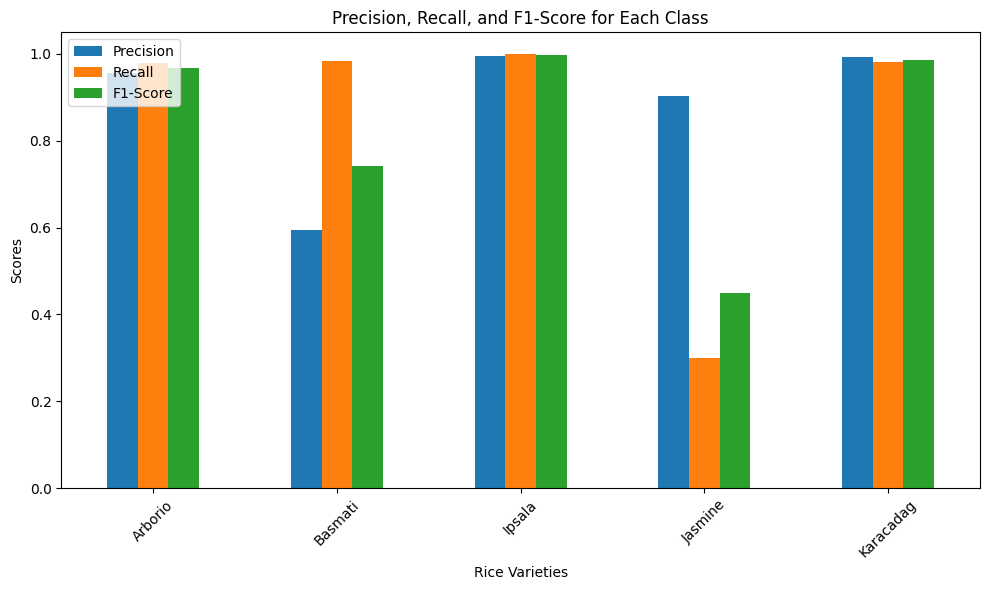


Classification Report on Test Data:

              precision    recall  f1-score   support

     Arborio       0.95      0.98      0.97      4500
     Basmati       0.60      0.98      0.74      4500
      Ipsala       1.00      1.00      1.00      4500
     Jasmine       0.90      0.30      0.45      4500
   Karacadag       0.99      0.98      0.99      4500

    accuracy                           0.85     22500
   macro avg       0.89      0.85      0.83     22500
weighted avg       0.89      0.85      0.83     22500


Visualizing Decision Boundaries with PCA Scatter Plot...


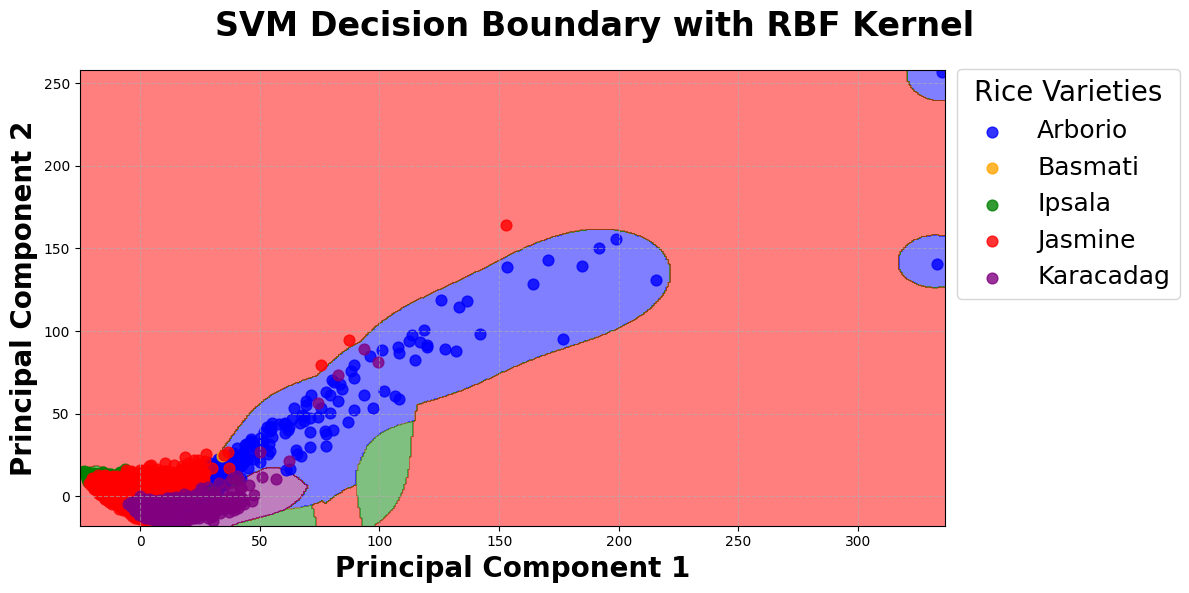


Test RMSE (Root Mean Square Error): 0.8233
Test MAE (Mean Absolute Error): 0.3154


In [ ]:
import joblib
import numpy as np
import pandas as pd
import cv2
from tqdm import tqdm
from joblib import Parallel, delayed
from sklearn.metrics import accuracy_score, confusion_matrix, precision_recall_fscore_support, classification_report, mean_squared_error, mean_absolute_error
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from matplotlib.colors import ListedColormap
import seaborn as sns
import matplotlib.pyplot as plt

# Function to extract RGB histograms from an image
def extract_histogram(img):
    hist_red = cv2.calcHist([img], [0], None, [256], [0, 256])  # Red channel
    hist_green = cv2.calcHist([img], [1], None, [256], [0, 256])  # Green channel
    hist_blue = cv2.calcHist([img], [2], None, [256], [0, 256])  # Blue channel
    return np.concatenate([hist_red.flatten(), hist_green.flatten(), hist_blue.flatten()])

# Function to process a single image
def process_image(category, i):
    img_path = f'{category}/{category} ({i}).jpg'
    img = cv2.imread(img_path)
    if img is not None:
        hist = extract_histogram(img)
        return hist, category
    return None, None

# Load test images in parallel with progress bar
def load_test_images(image_types, start_idx, end_idx):
    features, labels = [], []
    for category in image_types:
        with Parallel(n_jobs=-1, backend='loky') as parallel:
            results = list(
                tqdm(
                    parallel(
                        delayed(process_image)(category, i)
                        for i in range(start_idx, end_idx + 1)
                    ),
                    desc=f"Processing {category}",
                    leave=False
                )
            )
        category_features, category_labels = zip(*[res for res in results if res[0] is not None])
        features.extend(category_features)
        labels.extend([category] * len(category_features))
    return np.array(features), labels

# Load the optimized model and components
svm = joblib.load('RBF_svm_model_optimized_ten.pkl')
pca = joblib.load('RBF_pca_model_ten.pkl')
scaler = joblib.load('RBF_scaler_model_ten.pkl')
label_encoder = joblib.load('RBF_label_encoder_ten.pkl')

# Set parameters
image_types = ['Arborio', 'Basmati', 'Ipsala', 'Jasmine', 'Karacadag']
start_idx, end_idx = 10501, 15000

# Load test images
print("Loading and processing test images...")
test_features, test_labels = load_test_images(image_types, start_idx, end_idx)

# Preprocess test data
test_features_scaled = scaler.transform(test_features)
test_features_pca = pca.transform(test_features_scaled)
test_labels_encoded = label_encoder.transform(test_labels)

# Test the model on the new data
y_test_pred = svm.predict(test_features_pca)

# Accuracy on the test set
accuracy_test = accuracy_score(test_labels_encoded, y_test_pred)
print(f"\nTest Classification Accuracy: {accuracy_test * 100:.2f}%")

# Confusion Matrix
conf_matrix = confusion_matrix(test_labels_encoded, y_test_pred)

# Plot Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=image_types, yticklabels=image_types)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# Precision, Recall, and F1-Score
precision, recall, f1, _ = precision_recall_fscore_support(test_labels_encoded, y_test_pred, average=None)

# Create a DataFrame to show the scores
metrics_df = pd.DataFrame({
    'Precision': precision,
    'Recall': recall,
    'F1-Score': f1
}, index=image_types)

# Plot Precision, Recall, and F1-Score
metrics_df.plot(kind='bar', figsize=(10, 6))
plt.title('Precision, Recall, and F1-Score for Each Class')
plt.xlabel('Rice Varieties')
plt.ylabel('Scores')
plt.xticks(rotation=45)
plt.legend(loc='upper left')
plt.tight_layout()
plt.show()

# Display the classification report
print("\nClassification Report on Test Data:\n")
print(classification_report(test_labels_encoded, y_test_pred, target_names=image_types))

# PCA Scatter Plot with Decision Boundary
print("\nVisualizing Decision Boundaries with PCA Scatter Plot...")
pca_2d = PCA(n_components=2)
test_features_2d = pca_2d.fit_transform(test_features_scaled)

# Fit a new SVM for visualization
svm_2d = SVC(kernel='rbf', C=svm.C, gamma=svm.gamma, random_state=42)
svm_2d.fit(test_features_2d, test_labels_encoded)

# Create mesh grid for decision boundary
x_min, x_max = test_features_2d[:, 0].min() - 1, test_features_2d[:, 0].max() + 1
y_min, y_max = test_features_2d[:, 1].min() - 1, test_features_2d[:, 1].max() + 1
xx, yy = np.meshgrid(np.linspace(x_min, x_max, 500), np.linspace(y_min, y_max, 500))

# Predict on the mesh grid
Z = svm_2d.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

# Define a custom color map for each class
color_map = {
    'Arborio': 'blue',
    'Basmati': 'orange',
    'Ipsala': 'green',
    'Jasmine': 'red',
    'Karacadag': 'purple'
}

# Prepare a colormap for plotting decision boundaries
cmap = ListedColormap([color_map['Arborio'], color_map['Basmati'], color_map['Ipsala'], color_map['Jasmine'], color_map['Karacadag']])

# Create the plot
fig = plt.figure(figsize=(12, 6))
ax = fig.add_subplot(111)

# Plot the decision boundaries
ax.contourf(xx, yy, Z, alpha=0.5, cmap=cmap)

# Plot the data points with specified colors
for i, category in enumerate(image_types):
    idx = test_labels_encoded == i
    ax.scatter(
        test_features_2d[idx, 0],
        test_features_2d[idx, 1],
        label=category,
        s=60,
        alpha=0.8,
        color=color_map[category]
    )

# Customize plot settings
ax.set_xlabel('Principal Component 1', fontsize=20, weight='bold')
ax.set_ylabel('Principal Component 2', fontsize=20, weight='bold')
ax.legend(loc='upper left', bbox_to_anchor=(1, 1.03), fontsize=18, title='Rice Varieties', title_fontsize=20)
ax.grid(True, linestyle='--', alpha=0.6)

# Set plot title and layout
plt.tight_layout()
plt.suptitle('SVM Decision Boundary with RBF Kernel', fontsize=24, weight='bold')
plt.subplots_adjust(top=0.88)
plt.show()

# RMSE Calculation
rmse_test = np.sqrt(mean_squared_error(test_labels_encoded, y_test_pred))
print(f"\nTest RMSE (Root Mean Square Error): {rmse_test:.4f}")

# MAE Calculation
mae_test = mean_absolute_error(test_labels_encoded, y_test_pred)
print(f"Test MAE (Mean Absolute Error): {mae_test:.4f}")
